给定成对的'输入-输出'数据集$(x_1, y_1),...,(x_n, y_n)$，使得学习$f$来预测任意新
输入的$x$的输出$y$的$\hat{y} = f(x)$

$$
y_i = 2sin(x_i) + x_i^{0.8} + \epsilon
$$

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

n_train = 50 # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5) # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,)) # 训练样本的输出
x_test = torch.arange(0, 5, 0.1) # 测试样本
print(x_test)

y_truth = f(x_test) # 测试样本的真实输出
print(y_truth)
n_test = len(x_test)
n_test

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000,
        3.6000, 3.7000, 3.8000, 3.9000, 4.0000, 4.1000, 4.2000, 4.3000, 4.4000,
        4.5000, 4.6000, 4.7000, 4.8000, 4.9000])
tensor([0.0000, 0.3582, 0.6733, 0.9727, 1.2593, 1.5332, 1.7938, 2.0402, 2.2712,
        2.4858, 2.6829, 2.8616, 3.0211, 3.1607, 3.2798, 3.3782, 3.4556, 3.5122,
        3.5481, 3.5637, 3.5597, 3.5368, 3.4960, 3.4385, 3.3654, 3.2783, 3.1787,
        3.0683, 2.9489, 2.8223, 2.6905, 2.5554, 2.4191, 2.2835, 2.1508, 2.0227,
        1.9013, 1.7885, 1.6858, 1.5951, 1.5178, 1.4554, 1.4089, 1.3797, 1.3684,
        1.3759, 1.4027, 1.4490, 1.5151, 1.6009])


50

## 平均汇聚

基于平均汇聚来计算所有训练样本输出值的平均值

$$
f(x) = \frac{1}{n} \sum_{i=1}^n y_i
$$

In [4]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

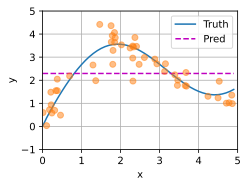

In [5]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

## 非参数注意力汇聚

根据输入的位置对输出$y_i$进行加权

$$
f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)}y_i
$$

其中$K$是核kernel, 上式称为$Nadaraya-Watson$核回归

可被改写为
$$
f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i
$$

注意力汇聚是$y_i$的加权平均，将查询$x$和键$x_i$之间的关系建模为 注意力权重

对于高斯核 Gaussian kernel

$$
K(u) = \frac{1}{\sqrt{2 \pi}} \exp(-\frac{u^2}{2})
$$

代入有：

$$
f(x) = \sum_{i=1}^n softmax(-\frac{1}{2}(x - x_i)^2) y_i
$$

如果一个键$x_i$越是接近给定的查询$x$, 那么分配给这个键对应值$y_i$的注意力权重就会越大

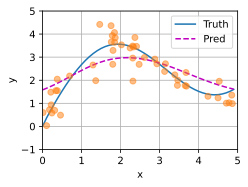

In [6]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

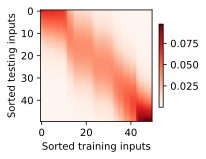

In [8]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

## 带参数注意力汇聚

$$
f(x) = \sum_{i=1}^n softmax(-\frac{1}{2}((x - x_i)w)^2)y_i
$$

In [9]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [18]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
print(weights.unsqueeze(1)) # (2, 1, 10)
print(values.unsqueeze(-1)) # (2, 10, 1)

torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1)).shape


tensor([[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]],

        [[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]]])
tensor([[[ 0.],
         [ 1.],
         [ 2.],
         [ 3.],
         [ 4.],
         [ 5.],
         [ 6.],
         [ 7.],
         [ 8.],
         [ 9.]],

        [[10.],
         [11.],
         [12.],
         [13.],
         [14.],
         [15.],
         [16.],
         [17.],
         [18.],
         [19.]]])


torch.Size([2, 1, 1])

In [19]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [20]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

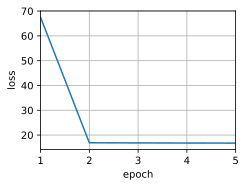

In [21]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

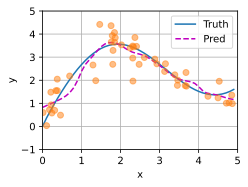

In [22]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

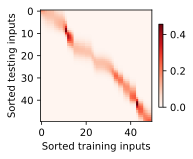

In [24]:
show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')